# Instructions for the Assignment

1. Unzip the whole zipped folder and not individual files
2. Don't rename the files. Still, if you wan't to rename them, copy to a new notebook
3. When uploading
        a) put your code in the unrenamed files
        b) copy both the unrenamed files with your code, even if you have done only 1 or done none, to a folder
        c) Rename the folder with your full ID
        d) zip the folder (.zip only) by right-cicking and "Send to"
        e) Upload the zipped file on to the portal
        f) If you get logged out during upload, log back in and check

# The Delivery Medoids

Let's say you're the strategic head at Amazon India, who plan to introduce improve their delivery system to better serve the Indian market. The existing delivery network is crappy, and simply transports items from the seller's location to the customer's location. To improve upon the network, the company wants to you to come up with the number of warehouses along with strategic locations which will be used to improve upon delivery times. 

For this task, you are given a dataset of $N$ cities each having their latitude, longitude, and the average number of deliveries made to the city per month. 

The first and probably the easiest method that comes to your mind is to apply the K-means algorithm to form $k$ clusters out of the $N$ cities such that the centroids of each of the $k$ clusters represent the location of a warehouse. But think on it again. Is it really a good idea?

Sooner or later, you realize that neither K Means nor Fuzzy C Means might be a good approach to the problem, simply because the centroids must _exist_. Common sense suggests that the warehouses must be built _within_ an existing city and not in a far off wasteland.

_What do you do now_ ? You think about tweaking the K means algorithm to choose a centroid out of the existing data points, and that is exactly what this problem is all about. We'll also find a way find the optimal number of warehouses required. But first, let's start off.

In [3]:
# We start with the standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
"""
Let's initialize a few arrays.
`data`       : an Nx4 array where the four columns represent
the name longitude, latitude and the monthly average number of
deliveries made in the city.

The following are slices into `data`.
`labels`     : an N dimensional array containing city names
`locations`  : an Nx2 array containing longitudes and latitudes
`deliveries` : an N dimensional array containing average deliveries
"""

data = np.load('data/cities.npy')
labels = data[:, 0]
locations = data[:, 1:3].astype(np.float64)
deliveries = data[:, 3].astype(np.float64)

Let's see what this data looks like.

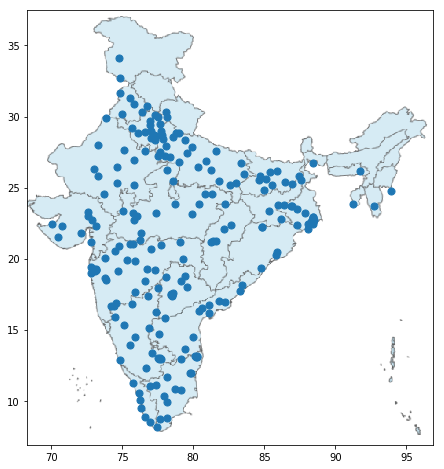

In [5]:
plt.figure(figsize=(8, 8))
# Plot column 1 (longitude) on the X axis and column 2 (latitude) on the Y axis.
plt.scatter(locations[:, 0], locations[:, 1], s=50)
# Plot an outline map of India, just for visualization
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])
plt.show()

One of the variants of the K means algorithm which might be useful in our case is the K medoids algorithm. Study the algorithm below.

## The K-Medoids Algorithm

Let's say we have $N$ data points $X_1, \ldots, X_N$ and wish to form $K$ clusters. Here's what the algorithm looks like.

<ol>
<li>Select initial centers $c_1,\ldots c_K$ according to a given metric, then repeat:
<ul>
    <li>Minimize over $C$:  
        for each $i=1,\ldots N$, find the cluster center $c_k$ closest to $X_i$, and let $C(i)=k$ 
    <li>Minimize over $c_1,\ldots c_K$:  
        for each $k=1,\ldots K$, assign $c_k = X^*_k$, which is the _medoid_ of points in cluster $k$. A medoid is the point $X_i$ in cluster $k$ that minimizes $$J = \sum_{C(j)=k} \|X_j-X_i\|_2^2$$
</ul>
<li>Stop when within-cluster variation doesn't change
</ol>

In words:
* Cluster (label) each point based on the closest center
* Replace each center by the medoid of points in its cluster


Note that if $A$ and $B$ are both $D$ dimensional vectors, $\| A - B \|_2$ is the $L_2$ norm, so that $\| A - B \|_2^2$ is essentially the sum of squared errors. i.e, $$\| A - B \|_2^2 = (A_1 - B_1)^2 + (A_2 - B_2)^2 \ldots (A_D - B_D)^2 $$

Now that you got a gist of the algorithm, read the docstrings in red highlighted in red and complete the functions below.

First, let's initialize the centres. It makes sense to initialize the centres with the $k$ most active cities in the dataset. 

## Task 1

Complete the function below

In [6]:
def initialize_centres(locations, deliveries, k):
    """
    Return the k most active cities.
    
    The more the number of average deliveries in a city, the more active it is.
    
    Out of the N cities described in `locations`, return a kx2 dimensional array
    containing the longitude and latitude of the `k` most active cities. The 
    array must be sorted in descending order according to the monthly average
    number of deliveries.
    
    Parameters
    ----------
    locations  : Nx2 dimensional numpy array
        locations[:, 0] and locations[:, 1] are the longitudes and latitudes
        of the N cities described by the array respectively.
    deliveries : N dimensional numpy array
        deliveries is the corresponding average monthly number of deliveries
        for each city described in locations
    k          : int
        The number of cities to return
    
    Returns
    -------
    centroids : kx2 dimensional numpy array
        The coordinates of the k most active cities.
        
    Hints
    -----
    See np.argsort()
    """
    indices = np.argsort(-deliveries)[:k]
    centres = locations[indices, :]
    return centres

In [7]:
# Test your implementation here
# Sample Test 1
answer = initialize_centres(locations, deliveries, 2)
expected = np.array([[72.82, 18.96],
                     [77.21, 28.67]])
assert np.allclose(answer, expected)

In [8]:
# [2 Mark] Hidden Test 1
# Do not edit this cell

In [9]:
# [2 Mark] Hidden Test 2
# Do not edit this cell

Let's plot the centres to see where exactly do they lie on a map.

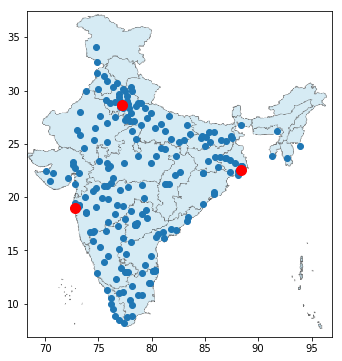

In [10]:
# Let's say we test for three clusters
K = 3
plt.figure(figsize=(6, 6))
plt.scatter(locations[:, 0], locations[:, 1])
centres = initialize_centres(locations, deliveries, K)
plt.scatter(centres[:, 0], centres[:, 1], c='r', s=100)
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])
plt.show()

If you see that the locations marked in red are metropolitans, you're probably going in the right direction.
Now that we have the initial centres, The next step is to associate every location with its closest centre. Since this is something that's been done repeatedly during the practise tests, the function is implemented below.

In [11]:
def closest_centre(locations, centres):
    """
    Returns an array containing the index to the nearest centre for each point.
    
    Notice that we use the squared L2 norm to calculate distances
    
    Parameters
    ----------
    locations : The Nx2 dimensional `locations` array, as described above
    centres   : A kx2 dimensional array obtained from initial_centres()
    
    Returns
    -------
    closest : N dimensional numpy array
        The index to the nearest centre.
    """
    distances = np.sum((locations - centres[:, None])**2, axis=2)
    closest = np.argmin(distances, axis=0)
    return closest

Let's plot the clusters. Convince yourself that the function returns the closest centres indeed.

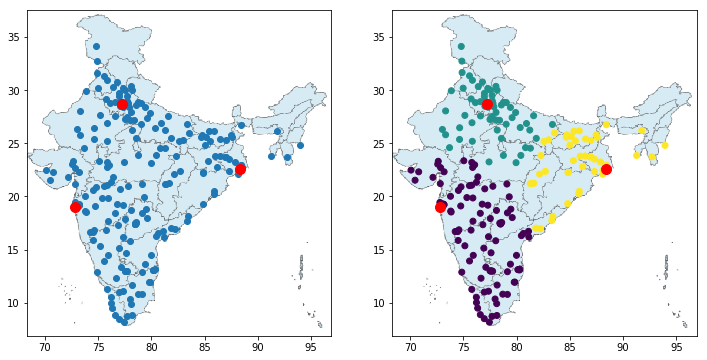

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(locations[:, 0], locations[:, 1])
centres = initialize_centres(locations, deliveries, K)
plt.scatter(centres[:, 0], centres[:, 1], c='r', s=100)
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])

closest = closest_centre(locations, centres)

plt.subplot(122)
plt.scatter(locations[:, 0], locations[:, 1], c=closest)
plt.scatter(centres[:, 0], centres[:, 1], c='r', s=100)
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])
plt.show()

The next step of the algorithm is to calculate a shift the existing centres to the new medoids. As described in the algorithm, you need to repeat the following for every cluster.

1. Calculate sum of squared L2 distances from every point in the cluster to every other point
2. The point which minimizes the above sum gets assigned as the new center 

## Task 2

Complete the function below

In [13]:
def shift_medoids(locations, closest, K):
    """
    Returns the new medoids for every cluster
        
    Parameters
    ----------
    locations : The Nx2 dimensional `locations` array, as described above
    closest   : An N dimensional array obtained from closest_centre()
    
    Returns
    -------
    centres : Nx2 dimensional numpy array containing the new centres
    
    Hints
    -----
    See np.sum(), np.argmin()
        
    """
    # A list to store the medoids obtained from every cluster
    centres = []
    # Iterate over every cluster
    for k in range(K):
        # separate out a cluster
        cluster = locations[closest==k]
        # calculate the medoid and assign it to a variable named `medoid`
        distmat = np.sum((cluster - cluster[:, None])**2, axis=2)
        ssd = np.sum(distmat, axis=1)
        medoid = cluster[np.argmin(ssd)]
        # print(k, np.min(ssd))
        centres.append(medoid)
    return np.array(centres)

In [14]:
# Test your implementation here
# Sample Test 2
data_test = np.load('data/cities.npy')
locations_test = data[:, 1:3].astype(np.float64)
closest_test = np.array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
                         1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
                         0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
                         1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
                         1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
                         0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
                         1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
                         0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
                         0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
                         1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1])

answer = shift_medoids(locations_test, closest_test, 2)
expected = np.array([[ 76.82,  17.34],
                    [ 81.84,  25.45]])
assert np.allclose(answer, expected)

In [15]:
# [2 Mark] Hidden Test 3
# Do not edit this cell

Once you're done calculating the medoids, Let's put it all back together.

In [16]:
def kmedoids(locations, deliveries, k):
    """The K-Medoids algorithm"""
    initial_centres = initialize_centres(locations, deliveries, k)
    centres = initial_centres
    old_centres = np.zeros_like(centres)
    while not np.allclose(centres, old_centres):
        old_centres = centres
        closest = closest_centre(locations, centres)
        centres = shift_medoids(locations, closest, k)
    return closest, centres, initial_centres

Let's plot the output to see how you've done.

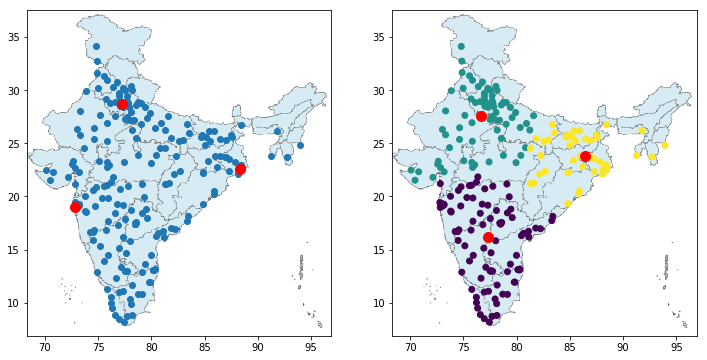

In [17]:
# Let's test for three clusters again
K = 3

closest, centres, initial_centres = kmedoids(locations, deliveries, K)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(locations[:, 0], locations[:, 1])
plt.scatter(initial_centres[:, 0], initial_centres[:, 1], c='r', s=100)
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])
plt.subplot(122)
plt.scatter(locations[:, 0], locations[:, 1], c=closest)
plt.scatter(centres[:, 0], centres[:, 1], c='r', s=100)
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])
plt.show()

So far so good. Now that we've implemented the clustering algorithm, let's turn to the question of determining the optimum number of clusters.

## Determining the number of clusters

A popular way to determine the best number of clusters is to plot a _distortion metric_ vs the number of clusters.
So once we're done with clustering for a given value of $K$, we define the distortion metric to be the sum of the objective functions for each cluster $k$. This is the same objective function that you minimized to calculate the medoids. For the sake of clarity, the distortion metric is described below.

Once you're done with clustering, this is how you calculate the distortion metric:

1. For every cluster $k$ , calculate value of the objective function. This is the same function that you minimized in order to calculate the medoid.  $$J = \sum_{C(j)=k} \|X_j-X_i\|_2^2$$
2. The value of the distortion metric is the sum of the values of the objective functions for all clusters. $$D = \sum_{k=1}^{K} \sum_{C(j)=k} \|X_j-X_i\|_2^2$$

## Task 3
Complete the function below

In [34]:
def distortion(locations, centres):
    """
    Return the distortion metric for a particular clustering.
        
    Parameters
    ----------
    locations : The Nx2 dimensional `locations` array, as described above
    centres   : A kx2 dimensional array obtained from kmedoids()
    
    Returns
    -------
    distortion : A float containing the value of the distortion metric
    
    Hints
    -----
    See np.sqrt(), np.sum(), np.min(), np.where(), np.nan(), np.nanmean()
        
    """
    # You are free to use loops and/or vectorization, whatever seems fit.
    answer = 0.0
    K = len(centres)
    # Iterate over every cluster
    for k in range(K):
        # separate out a cluster
        closest = closest_centre(locations, centres)
        cluster = locations[closest==k]
        # calculate the cluster's metric
        distmat = np.sum((cluster - cluster[:, None])**2, axis=2)
        ssd = np.sum(distmat, axis=1)
        answer += np.min(ssd)
    # print(answer)
    return answer

In [35]:
# Test your implementation here
# Sample Test 3
data_test = np.load('data/cities.npy')
locations_test = data[:, 1:3].astype(np.float64)
deliveries_test = data[:, 3].astype(np.float64)
_, centres_test, _ = kmedoids(locations_test, deliveries_test, 2)
answer = distortion(locations_test, centres_test)
expected = 1116.7649895432182
assert np.allclose(answer, expected)

AssertionError: 

In [36]:
# [3 Mark] Hidden Test 4
# Do not edit this cell

Let's plot the distortion metric vs K graph.

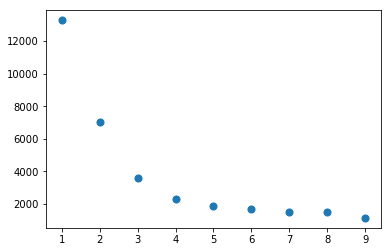

In [37]:
distortions = []
ks = []
for K in range(1, 10):
    closest, centres, _ = kmedoids(locations, deliveries, K)
    distortions.append(distortion(locations, centres))
    ks.append(K)
plt.scatter(ks, distortions, s=50)
plt.show()

You should notice that the value of the distortion metric decreases with increasing K. So essentially the distortion metric can be seen as the sum of squared distances travelled between each city and its centre. We choose the best number of clusters when adding an additional cluster does not significantly decrease this distortion metric. Our goal is to choose the best tradeoff, and we do that by choosing the _elbow_ point.

In [38]:
def elbow(distortions, ks):
    return ks[np.argmin(np.abs(np.diff(np.diff(distortions))))]
best_k = elbow(distortions, ks)

5 ['Faridabad' 'Guntur' 'Malegaon' 'Tiruppur' 'Kulti' 'Raichur']


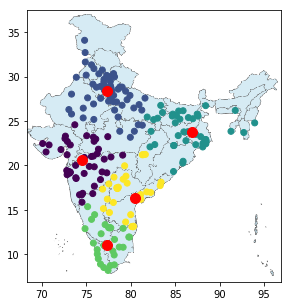

In [39]:
closest, centres, _ = kmedoids(locations, deliveries, best_k)
indices = np.any((data[:, 1:3] == centres[:, None]), axis=0)[:, 0]
cities = data[indices][:, 0]

print(best_k, cities)

plt.figure(figsize=(5, 5))
plt.scatter(locations[:, 0], locations[:, 1], c=closest)
plt.scatter(centres[:, 0], centres[:, 1], c='r', s=100)
plt.imshow(plt.imread("images/india.png"),zorder=0, extent=[68.3, 96.9,6.9, 37.5])
plt.show()